In [2]:
# Mounting the google drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/DSA3101 Group Project/')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['THE PLAYBOOK.pdf',
 'Meeting Minutes',
 'Video Script.gdoc',
 'DSA3101 Group 2 Contributions (Video).gsheet',
 'Customer Segmentation',
 'Tables Explanation.gsheet',
 'Project 3 Requirements.gdoc']

In [25]:
# Loading of packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.lines as mlines

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [89]:
# Importing of datasets

# Specify the correct path
file_path_1= '/content/drive/My Drive/DSA3101 Group Project/Customer Segmentation/Dataset/transactions_summary.csv'
file_path_2= '/content/drive/My Drive/DSA3101 Group Project/Customer Segmentation/Dataset/digital_usage.csv'
file_path_3= '/content/drive/My Drive/DSA3101 Group Project/Customer Segmentation/Dataset/customers.csv'

# Load the datasets
Transaction = pd.read_csv(file_path_1)
Usage = pd.read_csv(file_path_2)
Customers = pd.read_csv(file_path_3)

# Check the columns of the datasets
print(Transaction.columns)
print(Usage.columns)
print(Customers.columns)

Index(['customer_id', 'days_since_last_transaction', 'current_balance',
       'peak_month', 'peak_month_spending', 'peak_month_frequency',
       'total_transactions_3m', 'total_transactions_6m',
       'total_transactions_12m', 'total_transaction_amount_3m',
       'total_transaction_amount_6m', 'total_transaction_amount_12m',
       'average_transaction_amount_3m', 'average_transaction_amount_6m',
       'average_transaction_amount_12m', 'transaction_frequency_3m',
       'transaction_frequency_6m', 'transaction_frequency_12m',
       'high_value_transaction_rate_3m', 'high_value_transaction_rate_6m',
       'high_value_transaction_rate_12m', 'online_transaction_ratio_3m',
       'online_transaction_ratio_6m', 'online_transaction_ratio_12m'],
      dtype='object')
Index(['customer_id', 'has_mobile_app', 'has_web_account',
       'mobile_logins_per_week', 'web_logins_per_week',
       'avg_mobile_session_duration', 'avg_web_session_duration',
       'last_mobile_login', 'last_web_log

Now, we will clean the datasets before merging. Starting off with the Usage dataset

In [90]:
# Cleaning the Usage dataset
# Check for missing values
# print(Usage.isnull().sum())

# Check for 0 values in the datasets
# print((Usage == 0).sum())

# Check if Usage dataset is clean
print(Usage.describe())

# Check if last_mobile_login is null, the mobile_logins_per_week is 0, avg_mobile_session_duration is 0, and has_mobile_app is No
sum_mobile_null = Usage['last_mobile_login'].isnull().sum()
print(sum_mobile_null) # 1659
sum_mobile = 0
for _, row in Usage.iterrows():
    if row['has_mobile_app'] == 'No' and pd.isnull(row['last_mobile_login']) and row['mobile_logins_per_week'] == 0 and row['avg_mobile_session_duration'] == 0:
        sum_mobile += 1
print(sum_mobile) # 1659, the number matches as expected

# Check if last_web_login is null, the web_logins_per_week is 0, avg_web_session_duration is 0, and has_web_account is No
sum_web_null = Usage['last_web_login'].isnull().sum()
print(sum_web_null) # 1539
sum_web = 0
for _, row in Usage.iterrows():
    if row['has_web_account'] == 'No' and pd.isnull(row['last_web_login']) and row['web_logins_per_week'] == 0 and row['avg_web_session_duration'] == 0:
        sum_web += 1
print(sum_web) # 1539, the number matches as expected

# Check if last_mobile_login is null, the sum of mobile_logins_per_week is 0, avg_mobile_session_duration is 0, and has_mobile_app is No
sum_mobile = 0
for _, row in Usage.iterrows():
    if pd.isnull(row['last_mobile_login']):
        sum_mobile += row['mobile_logins_per_week'] + row['avg_mobile_session_duration'] + (1 if row['has_mobile_app'] == 'Yes' else 0)
print(sum_mobile) # 0, the number matches as expected

# Check if last_web_login is null, the sum of web_logins_per_week is 0, avg_web_session_duration is 0, and has_web_account is No
sum_web = 0
for _, row in Usage.iterrows():
    if pd.isnull(row['last_web_login']):
        sum_web += row['web_logins_per_week'] + row['avg_web_session_duration'] + (1 if row['has_web_account'] == 'Yes' else 0)
print(sum_web) # 0, the number matches as expected

# Changing Yes/No response to numerical response
columns_to_convert = ['has_mobile_app', 'has_web_account']
Usage[columns_to_convert] = Usage[columns_to_convert].replace({'Yes': 1, 'No': 0})

# Remove the last web/app log in
Usage = Usage.drop(columns=['last_mobile_login', 'last_web_login'])

print(Usage.head())

       customer_id  mobile_logins_per_week  web_logins_per_week  \
count  10000.00000            10000.000000          10000.00000   
mean    5000.50000                6.458500              5.06760   
std     2886.89568                3.546764              2.63684   
min        1.00000                0.000000              0.00000   
25%     2500.75000                5.000000              4.00000   
50%     5000.50000                7.000000              5.00000   
75%     7500.25000                9.000000              7.00000   
max    10000.00000               14.000000             11.00000   

       avg_mobile_session_duration  avg_web_session_duration  
count                 10000.000000              10000.000000  
mean                      3.030540                  4.471440  
std                       1.964464                  2.674307  
min                       0.000000                  0.000000  
25%                       1.600000                  2.800000  
50%               

<ipython-input-90-82b0caf5de5c>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Usage[columns_to_convert] = Usage[columns_to_convert].replace({'Yes': 1, 'No': 0})


This shows that the Usage dataset is clean. Now we will check if the Transaction dataset is clean.

In [91]:
# Cleaning the Transaction dataset
# Check for missing values
# print(Transaction.isnull().sum()) # 0

# Check for 0 values in the dataset
# print((Transaction == 0).sum()) # Multiple 0 values in the dataset

# Check the Statistics of the dataset
# print(Transaction.describe()) # Negative Balance, negative peak_month_spending, 0 values in the dataset

# Remove all the negative rows in the dataset
Transaction = Transaction[Transaction['current_balance'] >= 0]
Transaction = Transaction[Transaction['peak_month_spending'] >= 0]

print(Transaction.describe())

# Shape of the dataset
print(Transaction.shape) # 9940 rows and 24 columns

# Find the rows where average_transaction_amount_12m is 0
zero_avg_transaction = Transaction[Transaction['average_transaction_amount_12m'] == 0]
# Show in table format
display(zero_avg_transaction)

        customer_id  days_since_last_transaction  current_balance  \
count   9940.000000                  9940.000000      9940.000000   
mean    5000.387827                    23.904527      6835.469185   
std     2885.720548                    36.112473      4657.206812   
min        1.000000                     0.000000         0.000000   
25%     2501.750000                     5.000000      3670.094710   
50%     4999.500000                    14.000000      5884.822167   
75%     7499.250000                    26.000000      8863.982631   
max    10000.000000                   200.000000     39748.029652   

        peak_month  peak_month_spending  peak_month_frequency  \
count  9940.000000          9940.000000           9940.000000   
mean      6.613380         16752.335891             43.036519   
std       3.579621         17618.017033             11.596799   
min       1.000000             0.000000             12.000000   
25%       3.000000          6019.524591             3

,customer_id,days_since_last_transaction,current_balance,peak_month,peak_month_spending,peak_month_frequency,total_transactions_3m,total_transactions_6m,total_transactions_12m,total_transaction_amount_3m,...,average_transaction_amount_12m,transaction_frequency_3m,transaction_frequency_6m,transaction_frequency_12m,high_value_transaction_rate_3m,high_value_transaction_rate_6m,high_value_transaction_rate_12m,online_transaction_ratio_3m,online_transaction_ratio_6m,online_transaction_ratio_12m
7120,7121,130,0.0,9,0.0,16,0,112,162,0.0,...,0.0,0.000000,18.666667,13.500000,0.000000,0.098214,0.049383,0.000000,0.470890,0.510629
8160,8161,4,0.0,7,0.0,35,88,171,320,0.0,...,0.0,29.333333,28.500000,26.666667,0.034091,0.046784,0.037500,0.726451,0.672533,0.628687


From the above cleaning, we have removed the negative values by eliminating the entire row. We kept the 0 values since there could be a possibility (low) that current balance is 0 and therefore the rest of the transaction information is 0 as well.

We will now clean the Customer dataset and experiment customer segmentation with just the Customer dataset alone



In [92]:
# Load data
customer_data = pd.read_csv(file_path_3)

# Data cleaning and processing
columns_to_convert = ['credit_default', 'credit_card', 'personal_loan', 'mortgage', 'savings_account', 'investment_product', 'auto_loan', 'wealth_management']
customer_data[columns_to_convert] = customer_data[columns_to_convert].replace({'yes': 1, 'no': 0})
customer_data = customer_data[customer_data['income'] >= 0] # Filter out entries with negative income
customer_data = customer_data[customer_data['age'] >= 21] # Filter out non-adults
customer_data = customer_data[customer_data['created_at'] < '2025-03-01'] # Filter out erroneous entries
customer_data = customer_data.drop(columns=['created_at']) # Remove column
customer_data_original = customer_data.copy() # To be used for merging
customer_data = customer_data.drop(columns=['customer_id']) # Remove column

# Show first few entries
customer_data.head()

<ipython-input-92-ec454b8aa82a>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_data[columns_to_convert] = customer_data[columns_to_convert].replace({'yes': 1, 'no': 0})


,age,job,marital,education,credit_default,customer_segment,region,income,credit_card,personal_loan,mortgage,savings_account,investment_product,auto_loan,wealth_management
0,38,blue-collar,married,secondary,0,High-Value,Urban,2603,1,1,1,1,1,1,1
2,73,services,divorced,secondary,0,Budget-Conscious,Urban,3130,1,0,0,0,1,1,0
3,87,retired,married,primary,0,Retired,Urban,2401,1,1,0,1,0,0,0
5,46,technician,married,tertiary,0,Middle-Market,Urban,3355,1,1,0,1,0,1,1
6,70,admin,married,tertiary,0,Budget-Conscious,Urban,4918,1,1,1,1,0,1,0


In [93]:
# Create one hot encoding for categorical variables
customer_data_encoded = pd.get_dummies(customer_data)

# Standardise the data
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(customer_data_encoded)
scaled_data.shape

(9429, 34)

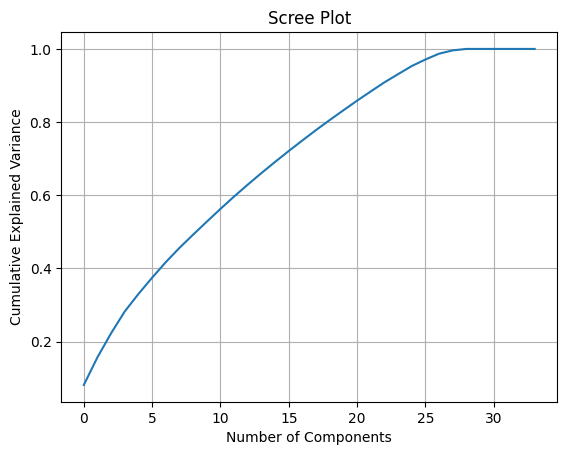

In [94]:
# Create a Scree Plot to decide the number of components to use
pca = PCA().fit(scaled_data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

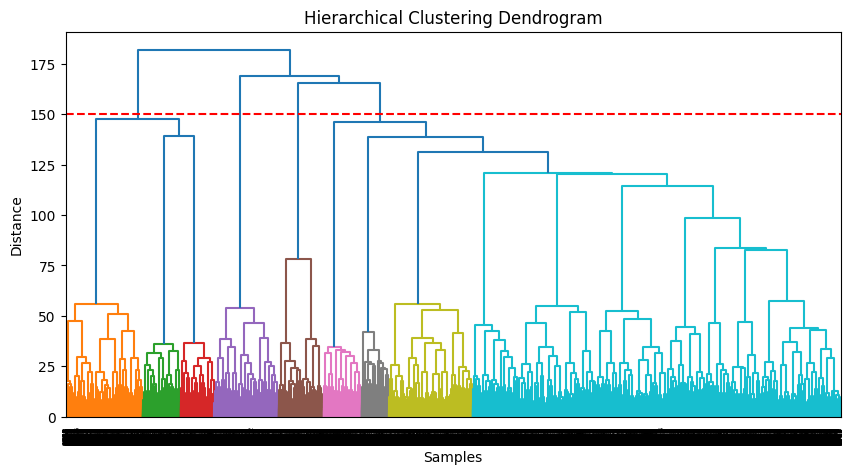

In [95]:
pca = PCA(n_components=25)  # Reduce to 25 dimensions (chosen from Scree Plot)
scaled_data_pca = pca.fit_transform(scaled_data)  # Transform data

# Compute hierarchical clustering
linkage_matrix = linkage(scaled_data_pca, method='ward')  # Ward's method for variance minimisation

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.axhline(y=150, color='r', linestyle='--')  # Adjust threshold based on the plot
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [96]:
# Assign cluster labels (decide number of clusters from dendrogram)
n_clusters = 4
cluster_labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(scaled_data_pca)

print(f"Cluster assignments: {np.unique(cluster_labels, return_counts=True)}")
cluster_labels

Cluster assignments: (array([0, 1, 2, 3]), array([1809, 6291,  781,  548]))


array([1, 1, 2, ..., 1, 2, 1])

In [97]:
# Merge cluster labels with the customer dataset
customer_data_with_labels = customer_data
customer_data_with_labels['cluster'] = cluster_labels

# Count the numbers in each cluster
customer_data_with_labels['cluster'].value_counts()

,count
cluster,
1,6291
0,1809
2,781
3,548


In [98]:
# Find the most common traits of each cluster, and count of each traits
unique_traits = {}
for cluster_id in range(n_clusters):
    cluster_data = customer_data_with_labels[customer_data_with_labels['cluster'] == cluster_id]
    unique_traits[cluster_id] = cluster_data.drop(columns=['cluster']).mode().iloc[0]
    print(f"Cluster {cluster_id}:")
    print(unique_traits[cluster_id])
    print()
    print(f"Number of customers in cluster {cluster_id}: {len(cluster_data)}")
    print()


Cluster 0:
age                              43
job                      management
marital                     married
education                  tertiary
credit_default                    0
customer_segment      Middle-Market
region                        Urban
income                         6753
credit_card                       1
personal_loan                     1
mortgage                          1
savings_account                   1
investment_product                1
auto_loan                         1
wealth_management                 0
Name: 0, dtype: object

Number of customers in cluster 0: 1809

Cluster 1:
age                            46.0
job                     blue-collar
marital                     married
education                 secondary
credit_default                  0.0
customer_segment      Middle-Market
region                        Urban
income                         2628
credit_card                     1.0
personal_loan                   1.0
mortgage      

As we can see, cluster 0 is the high-valued, cluster 1 is middle income, cluster 2 is retiree, and cluster 3 is young adults/interns


In [99]:
# Each cluster statistical distributions

# For cluster 0
cluster_0_data = customer_data_with_labels[customer_data_with_labels['cluster'] == 0]
print('For Cluster 0')
print(cluster_0_data.describe()) # Mean income of $6268

# For cluster 1
cluster_1_data = customer_data_with_labels[customer_data_with_labels['cluster'] == 1]
print('For Cluster 1')
print(cluster_1_data.describe()) # Mean income of $2875

# For cluster 2
cluster_2_data = customer_data_with_labels[customer_data_with_labels['cluster'] == 2]
print('For Cluster 2')
print(cluster_2_data.describe()) # Mean income of $2623

# For cluster 3
cluster_3_data = customer_data_with_labels[customer_data_with_labels['cluster'] == 3]
print('For Cluster 3')
print(cluster_3_data.describe()) # Mean income of $1953

For Cluster 0
               age  credit_default        income  credit_card  personal_loan  \
count  1809.000000          1809.0   1809.000000  1809.000000    1809.000000   
mean     45.149807             0.0   6268.793256     0.889994       0.540077   
std      12.067803             0.0   2180.624361     0.312983       0.498529   
min      21.000000             0.0   1519.000000     0.000000       0.000000   
25%      37.000000             0.0   4808.000000     1.000000       0.000000   
50%      44.000000             0.0   6263.000000     1.000000       1.000000   
75%      53.000000             0.0   8053.000000     1.000000       1.000000   
max      99.000000             0.0  14272.000000     1.000000       1.000000   

          mortgage  savings_account  investment_product    auto_loan  \
count  1809.000000      1809.000000         1809.000000  1809.000000   
mean      0.607518         0.906578            0.562189     0.729685   
std       0.488438         0.291103            0.

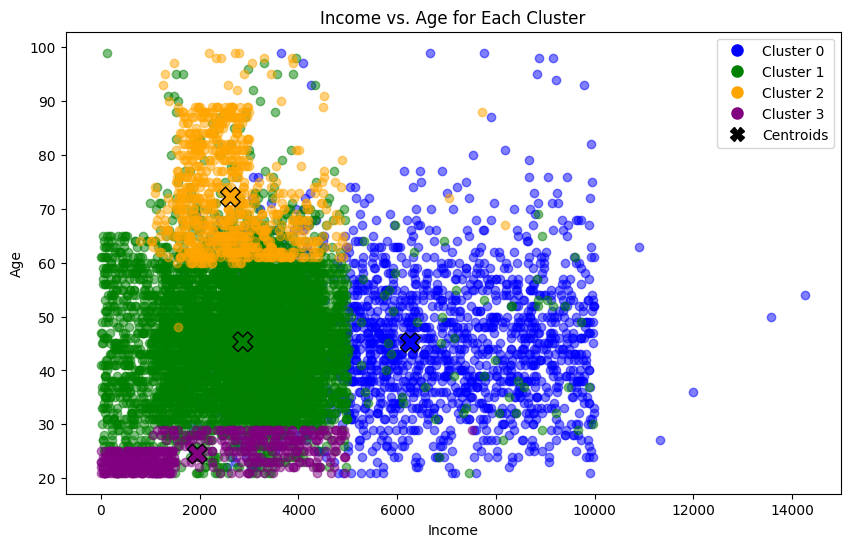

In [100]:
# Visualise the different clusters of Age against Income

# Define colors for clusters
colors = ['blue', 'green', 'orange', 'purple']

# Create figure
plt.figure(figsize=(10, 6))

# Scatter plots for each cluster with transparency
plt.scatter(cluster_0_data['income'], cluster_0_data['age'], label='Cluster 0', color=colors[0], alpha=0.5)
plt.scatter(cluster_1_data['income'], cluster_1_data['age'], label='Cluster 1', color=colors[1], alpha=0.5)
plt.scatter(cluster_2_data['income'], cluster_2_data['age'], label='Cluster 2', color=colors[2], alpha=0.5)
plt.scatter(cluster_3_data['income'], cluster_3_data['age'], label='Cluster 3', color=colors[3], alpha=0.5)

# Compute cluster centroids
centroids = np.array([
    [cluster_0_data['income'].mean(), cluster_0_data['age'].mean()],
    [cluster_1_data['income'].mean(), cluster_1_data['age'].mean()],
    [cluster_2_data['income'].mean(), cluster_2_data['age'].mean()],
    [cluster_3_data['income'].mean(), cluster_3_data['age'].mean()]
])

# Plot centroids in respective cluster colors
plt.scatter(centroids[:, 0], centroids[:, 1], color=colors, s=200, marker='X', edgecolors='black')

# Create a custom legend handle for centroids (black color)
centroid_legend = mlines.Line2D([], [], color='black', marker='X', linestyle='None', markersize=10, label='Centroids')

# Add legend with custom centroid handle
plt.xlabel('Income')
plt.ylabel('Age')
plt.title('Income vs. Age for Each Cluster')
plt.legend(handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=8, label=f'Cluster {i}') for i, color in enumerate(colors)] + [centroid_legend])
plt.show()


This shows that the hierarchical clustering does a good job in clustering the customers into 4 different segments.

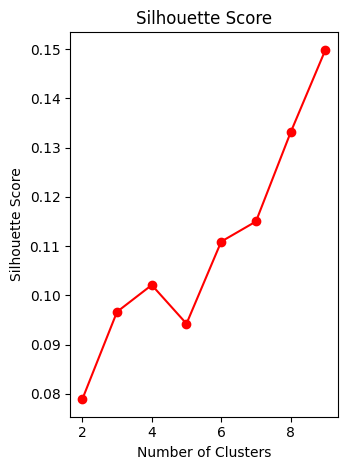

In [103]:
# Find the optimal number of clusters for KMeans
silhouette_scores = []
cluster_range = range(2, 10)  # Start from 3 clusters to max 9 clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data_pca)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(scaled_data_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='r')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [104]:
# K-means Clustering
# Apply K-Means with chosen K (K=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data_pca)

# Add cluster labels to the dataset
customer_data_with_labels_kmean = customer_data
customer_data_with_labels_kmean['Cluster'] = cluster_labels

# Find the most common traits of each cluster, and count of each traits
unique_traits = {}
n_clusters = 4
for cluster_id in range(n_clusters):
    cluster_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == cluster_id]
    unique_traits[cluster_id] = cluster_data.drop(columns=['Cluster']).mode().iloc[0]
    print(f"Cluster {cluster_id}:")
    print(unique_traits[cluster_id])
    print()
    print(f"Number of customers in cluster {cluster_id}: {len(cluster_data)}")
    print()

# Each cluster statistical distributions
# For cluster 0
cluster_0_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == 0]
print('For Cluster 0')
print(cluster_0_data.describe()) # Mean income of $2685

# For cluster 1
cluster_1_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == 1]
print('For Cluster 1')
print(cluster_1_data.describe()) # Mean income of $2954

# For cluster 2
cluster_2_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == 2]
print('For Cluster 2')
print(cluster_2_data.describe()) # Mean income of $2703

# For cluster 3
cluster_3_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == 3]
print('For Cluster 3')
print(cluster_3_data.describe()) # Mean income of $7289


Cluster 0:
age                                  25.0
job                           blue-collar
marital                            single
education                       secondary
credit_default                        0.0
customer_segment      Young Professionals
region                              Urban
income                                729
credit_card                           1.0
personal_loan                         1.0
mortgage                              0.0
savings_account                       1.0
investment_product                    0.0
auto_loan                             1.0
wealth_management                     0.0
cluster                               1.0
Name: 0, dtype: object

Number of customers in cluster 0: 2088

Cluster 1:
age                              46
job                     blue-collar
marital                     married
education                 secondary
credit_default                    0
customer_segment      Middle-Market
region                    

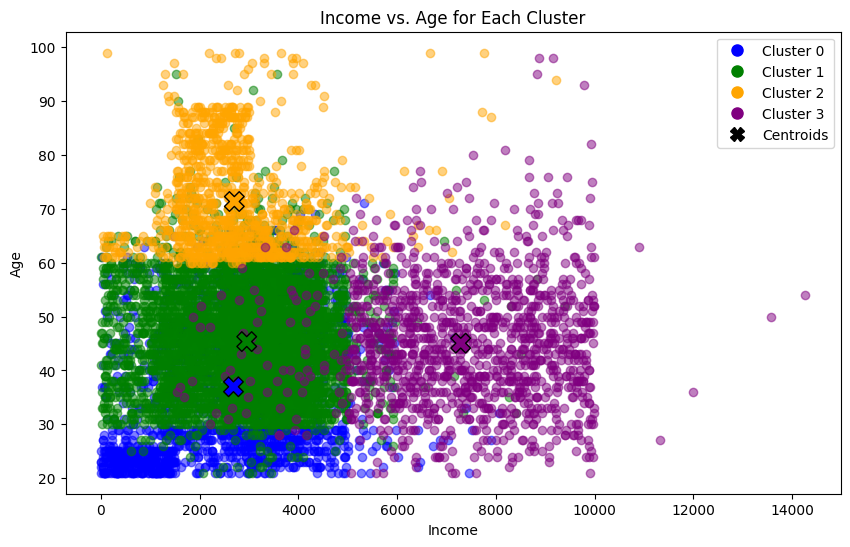

In [105]:
# Visualise the different clusters of Age against Income

# Define colors for clusters
colors = ['blue', 'green', 'orange', 'purple']

# Create figure
plt.figure(figsize=(10, 6))

# Scatter plots for each cluster with transparency
plt.scatter(cluster_0_data['income'], cluster_0_data['age'], label='Cluster 0', color=colors[0], alpha=0.5)
plt.scatter(cluster_1_data['income'], cluster_1_data['age'], label='Cluster 1', color=colors[1], alpha=0.5)
plt.scatter(cluster_2_data['income'], cluster_2_data['age'], label='Cluster 2', color=colors[2], alpha=0.5)
plt.scatter(cluster_3_data['income'], cluster_3_data['age'], label='Cluster 3', color=colors[3], alpha=0.5)

# Compute cluster centroids
centroids = np.array([
    [cluster_0_data['income'].mean(), cluster_0_data['age'].mean()],
    [cluster_1_data['income'].mean(), cluster_1_data['age'].mean()],
    [cluster_2_data['income'].mean(), cluster_2_data['age'].mean()],
    [cluster_3_data['income'].mean(), cluster_3_data['age'].mean()]
])

# Plot centroids in respective cluster colors
plt.scatter(centroids[:, 0], centroids[:, 1], color=colors, s=200, marker='X', edgecolors='black')

# Create a custom legend handle for centroids (black color)
centroid_legend = mlines.Line2D([], [], color='black', marker='X', linestyle='None', markersize=10, label='Centroids')

# Add legend with custom centroid handle
plt.xlabel('Income')
plt.ylabel('Age')
plt.title('Income vs. Age for Each Cluster')
plt.legend(handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=8, label=f'Cluster {i}') for i, color in enumerate(colors)] + [centroid_legend])
plt.show()

Both KMeans and Hierarchical clustering have shown to have segment the customers effectively based on the scatter plots. We will now merge the customer dataset with transaction and usage dataset implement the same models as above

In [109]:
# Merge the datasets
df = pd.merge(customer_data_original, Transaction, on='customer_id', how='inner')
df = pd.merge(df, Usage, on='customer_id', how='inner')

# Check the shape of the merge dataset
print(df.shape) # 9429 rows
print(df.columns)

(9429, 45)
Index(['customer_id', 'age', 'job', 'marital', 'education', 'credit_default',
       'customer_segment', 'region', 'income', 'credit_card', 'personal_loan',
       'mortgage', 'savings_account', 'investment_product', 'auto_loan',
       'wealth_management', 'days_since_last_transaction', 'current_balance',
       'peak_month', 'peak_month_spending', 'peak_month_frequency',
       'total_transactions_3m', 'total_transactions_6m',
       'total_transactions_12m', 'total_transaction_amount_3m',
       'total_transaction_amount_6m', 'total_transaction_amount_12m',
       'average_transaction_amount_3m', 'average_transaction_amount_6m',
       'average_transaction_amount_12m', 'transaction_frequency_3m',
       'transaction_frequency_6m', 'transaction_frequency_12m',
       'high_value_transaction_rate_3m', 'high_value_transaction_rate_6m',
       'high_value_transaction_rate_12m', 'online_transaction_ratio_3m',
       'online_transaction_ratio_6m', 'online_transaction_ratio_12m'

In [110]:
# Remove 'customer_id' column
df = df.drop('customer_id', axis=1)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(df_encoded.head())

# Standardise the data
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(df_encoded)
scaled_data.shape # 9429 Rows

   age  credit_default  income  credit_card  personal_loan  mortgage  \
0   38               0    2603            1              1         1   
1   73               0    3130            1              0         0   
2   87               0    2401            1              1         0   
3   46               0    3355            1              1         0   
4   70               0    4918            1              1         1   

   savings_account  investment_product  auto_loan  wealth_management  ...  \
0                1                   1          1                  1  ...   
1                0                   1          1                  0  ...   
2                1                   0          0                  0  ...   
3                1                   0          1                  1  ...   
4                1                   0          1                  0  ...   

   marital_married  marital_single  education_secondary  education_tertiary  \
0             True       

(9429, 58)

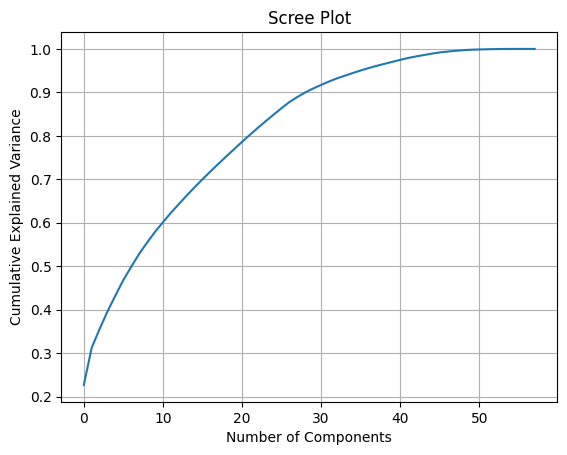

In [111]:
# Create a Scree Plot to decide the number of components to use
pca = PCA().fit(scaled_data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

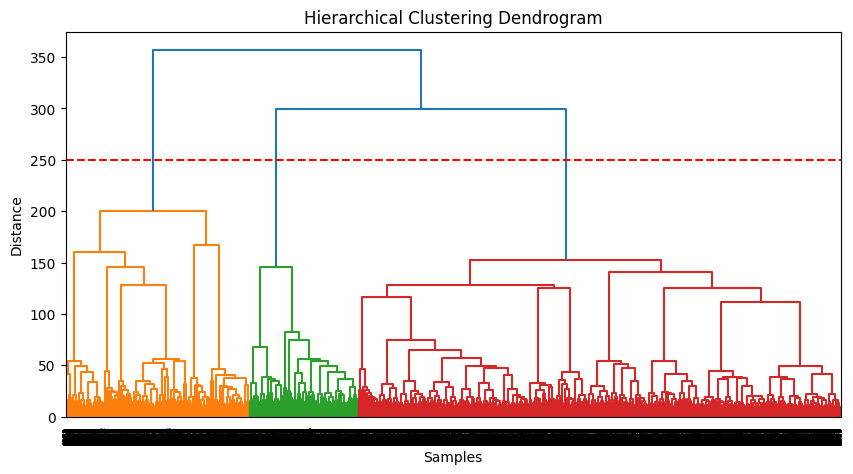

In [112]:
pca = PCA(n_components=40)  # Reduce to 40 dimensions (chosen from Scree Plot)
scaled_data_pca = pca.fit_transform(scaled_data)  # Transform data

# Compute hierarchical clustering
linkage_matrix = linkage(scaled_data_pca, method='ward')  # Ward's method for variance minimisation

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.axhline(y=250, color='r', linestyle='--')  # Adjust threshold based on the plot
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [116]:
# Assign cluster labels (decide number of clusters from dendrogram)
n_clusters = 3
cluster_labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(scaled_data_pca)

print(f"Cluster assignments: {np.unique(cluster_labels, return_counts=True)}")
cluster_labels

Cluster assignments: (array([0, 1, 2]), array([2244, 5862, 1323]))


array([1, 0, 0, ..., 0, 0, 1])

In [119]:
# Merge cluster labels with the customer dataset
customer_data_with_labels = df
customer_data_with_labels['cluster'] = cluster_labels

# Count the numbers in each cluster
customer_data_with_labels['cluster'].value_counts()

,count
cluster,
1,5862
0,2244
2,1323


In [120]:
# Find the most common traits of each cluster, and count of each traits
unique_traits = {}
for cluster_id in range(n_clusters):
    cluster_data = customer_data_with_labels[customer_data_with_labels['cluster'] == cluster_id]
    unique_traits[cluster_id] = cluster_data.drop(columns=['cluster']).mode().iloc[0]
    print(f"Cluster {cluster_id}:")
    print(unique_traits[cluster_id])
    print()
    print(f"Number of customers in cluster {cluster_id}: {len(cluster_data)}")
    print()

Cluster 0:
age                                     61.0
job                                  retired
marital                              married
education                          secondary
credit_default                           0.0
customer_segment                     Retired
region                                 Urban
income                                2270.0
credit_card                              1.0
personal_loan                            1.0
mortgage                                 0.0
savings_account                          1.0
investment_product                       0.0
auto_loan                                1.0
wealth_management                        0.0
days_since_last_transaction              0.0
current_balance                          0.0
peak_month                              12.0
peak_month_spending                      0.0
peak_month_frequency                    28.0
total_transactions_3m                    0.0
total_transactions_6m                    0.0

In [122]:
# Each cluster statistical distributions

# For cluster 0
cluster_0_data = customer_data_with_labels[customer_data_with_labels['cluster'] == 0]
print('For Cluster 0')
print(cluster_0_data.describe()) # Mean income of $2162

# For cluster 1
cluster_1_data = customer_data_with_labels[customer_data_with_labels['cluster'] == 1]
print('For Cluster 1')
print(cluster_1_data.describe()) # Mean income of $3156

# For cluster 2
cluster_2_data = customer_data_with_labels[customer_data_with_labels['cluster'] == 2]
print('For Cluster 2')
print(cluster_2_data.describe()) # Mean income of $6949

For Cluster 0
               age  credit_default       income  credit_card  personal_loan  \
count  2244.000000     2244.000000  2244.000000  2244.000000    2244.000000   
mean     55.274955        0.040553  2162.473708     0.712121       0.642602   
std      19.755746        0.197295  1581.974932     0.452875       0.479340   
min      21.000000        0.000000     0.000000     0.000000       0.000000   
25%      38.000000        0.000000   819.750000     0.000000       0.000000   
50%      61.000000        0.000000  2044.000000     1.000000       1.000000   
75%      68.000000        0.000000  3038.000000     1.000000       1.000000   
max      99.000000        1.000000  9967.000000     1.000000       1.000000   

          mortgage  savings_account  investment_product    auto_loan  \
count  2244.000000      2244.000000         2244.000000  2244.000000   
mean      0.442068         0.877005            0.279412     0.555258   
std       0.496743         0.328504            0.448810   

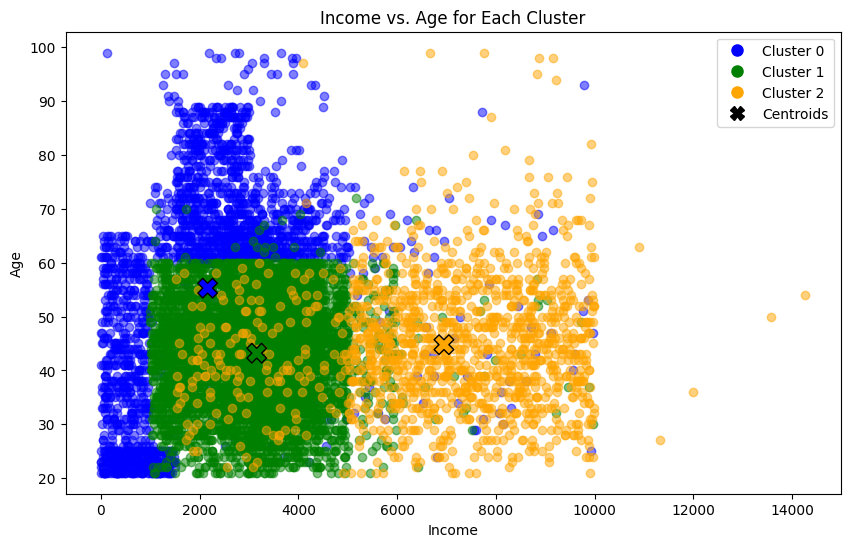

In [123]:
# Visualise the different clusters of Age against Income

# Define colors for clusters
colors = ['blue', 'green', 'orange']

# Create figure
plt.figure(figsize=(10, 6))

# Scatter plots for each cluster with transparency
plt.scatter(cluster_0_data['income'], cluster_0_data['age'], label='Cluster 0', color=colors[0], alpha=0.5)
plt.scatter(cluster_1_data['income'], cluster_1_data['age'], label='Cluster 1', color=colors[1], alpha=0.5)
plt.scatter(cluster_2_data['income'], cluster_2_data['age'], label='Cluster 2', color=colors[2], alpha=0.5)

# Compute cluster centroids
centroids = np.array([
    [cluster_0_data['income'].mean(), cluster_0_data['age'].mean()],
    [cluster_1_data['income'].mean(), cluster_1_data['age'].mean()],
    [cluster_2_data['income'].mean(), cluster_2_data['age'].mean()]
])

# Plot centroids in respective cluster colors
plt.scatter(centroids[:, 0], centroids[:, 1], color=colors, s=200, marker='X', edgecolors='black')

# Create a custom legend handle for centroids (black color)
centroid_legend = mlines.Line2D([], [], color='black', marker='X', linestyle='None', markersize=10, label='Centroids')

# Add legend with custom centroid handle
plt.xlabel('Income')
plt.ylabel('Age')
plt.title('Income vs. Age for Each Cluster')
plt.legend(handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=8, label=f'Cluster {i}') for i, color in enumerate(colors)] + [centroid_legend])
plt.show()

Now we will move on to KMeans Clustering

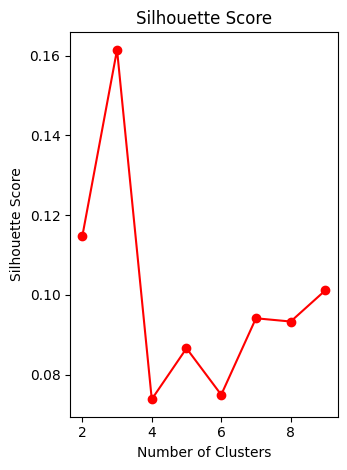

In [124]:
# Find the optimal number of clusters for KMeans
silhouette_scores = []
cluster_range = range(2, 10)  # Start from 3 clusters to max 9 clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data_pca)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(scaled_data_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='r')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [125]:
# K-means Clustering
# Apply K-Means with chosen K (K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the dataset
customer_data_with_labels_kmean = df_encoded
customer_data_with_labels_kmean['Cluster'] = cluster_labels

# Find the most common traits of each cluster, and count of each traits
unique_traits = {}
n_clusters = 3
for cluster_id in range(n_clusters):
    cluster_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == cluster_id]
    unique_traits[cluster_id] = cluster_data.drop(columns=['Cluster']).mode().iloc[0]
    print(f"Cluster {cluster_id}:")
    print(unique_traits[cluster_id])
    print()
    print(f"Number of customers in cluster {cluster_id}: {len(cluster_data)}")
    print()

# Each cluster statistical distributions
# For cluster 0
cluster_0_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == 0]
print('For Cluster 0')
print(cluster_0_data.describe()) # Mean income of $7127

# For cluster 1
cluster_1_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == 1]
print('For Cluster 1')
print(cluster_1_data.describe()) # Mean income of $2988

# For cluster 2
cluster_2_data = customer_data_with_labels_kmean[customer_data_with_labels_kmean['Cluster'] == 2]
print('For Cluster 2')
print(cluster_2_data.describe()) # Mean income of $2154


Cluster 0:
age                                             48.0
credit_default                                   0.0
income                                        5921.0
credit_card                                      1.0
personal_loan                                    1.0
mortgage                                         1.0
savings_account                                  1.0
investment_product                               1.0
auto_loan                                        1.0
wealth_management                                0.0
days_since_last_transaction                      0.0
current_balance                          3774.374692
peak_month                                      12.0
peak_month_spending                      5417.369485
peak_month_frequency                            53.0
total_transactions_3m                          118.0
total_transactions_6m                          232.0
total_transactions_12m                         507.0
total_transaction_amount_3m        

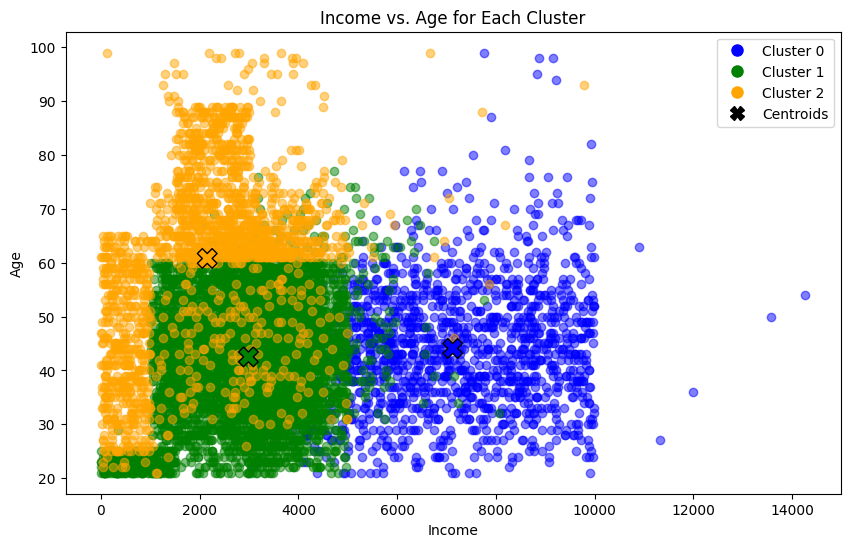

In [126]:
# Visualise the different clusters of Age against Income

# Define colors for clusters
colors = ['blue', 'green', 'orange']

# Create figure
plt.figure(figsize=(10, 6))

# Scatter plots for each cluster with transparency
plt.scatter(cluster_0_data['income'], cluster_0_data['age'], label='Cluster 0', color=colors[0], alpha=0.5)
plt.scatter(cluster_1_data['income'], cluster_1_data['age'], label='Cluster 1', color=colors[1], alpha=0.5)
plt.scatter(cluster_2_data['income'], cluster_2_data['age'], label='Cluster 2', color=colors[2], alpha=0.5)

# Compute cluster centroids
centroids = np.array([
    [cluster_0_data['income'].mean(), cluster_0_data['age'].mean()],
    [cluster_1_data['income'].mean(), cluster_1_data['age'].mean()],
    [cluster_2_data['income'].mean(), cluster_2_data['age'].mean()]
])

# Plot centroids in respective cluster colors
plt.scatter(centroids[:, 0], centroids[:, 1], color=colors, s=200, marker='X', edgecolors='black')

# Create a custom legend handle for centroids (black color)
centroid_legend = mlines.Line2D([], [], color='black', marker='X', linestyle='None', markersize=10, label='Centroids')

# Add legend with custom centroid handle
plt.xlabel('Income')
plt.ylabel('Age')
plt.title('Income vs. Age for Each Cluster')
plt.legend(handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=8, label=f'Cluster {i}') for i, color in enumerate(colors)] + [centroid_legend])
plt.show()